#### Import neccessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import re

#### Read in data files

In [2]:
# Read in CSV File
document_check = 'document_check_sample.csv'
facial_report = 'facial_report_sample.csv'

document_df = pd.read_csv(document_check)
facial_df = pd.read_csv(facial_report)


## Understanding the data

In [3]:
# Understand the attributes
document_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11760 entries, 0 to 11759
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          5880 non-null   float64
 1   user_id                             5880 non-null   object 
 2   result                              5880 non-null   object 
 3   visual_authenticity_result          4991 non-null   object 
 4   image_integrity_result              5880 non-null   object 
 5   face_detection_result               4990 non-null   object 
 6   image_quality_result                5880 non-null   object 
 7   created_at                          5880 non-null   object 
 8   supported_document_result           5869 non-null   object 
 9   conclusive_document_quality_result  3140 non-null   object 
 10  colour_picture_result               3140 non-null   object 
 11  data_validation_result              4739 

## Processing

#### Dropping null vales (missing values)
- Based on the information above, there are 11760 entries, however there are only 5880 rows with result. Which means we canont make any assumption out of the rows with no result
- Hence, I will decide to drop all those rows

In [4]:
# Dropping the rows with Na values for result
document_df = document_df.dropna(subset=['result']).reset_index(drop=True)
facial_df = facial_df.dropna(subset=['result']).reset_index(drop=True)

## Document_check_sample File
Things we will do to the document file 
- Keep only relevant attributes 
- This is a time series problem -> ensure the date time format, sort the data according to the time 
- Generate visualization to understand how each attribute change over time 
- Handle the attribute 'property' separately due to difference data type
- Select the attribute with noticable changes that might affect the final result 
- Confirm the assumption about that attribute using chi-square techniche: finding the relevance of categorical data 

#### Convert 'created_at' to the right format
- Currently, the date time is object so it will not be sorted correctly. We will convert that to date-time format

In [5]:
# Currently, the date time is object so it will not be sorted correctly. We will convert that to date-time format

document_df['created_at'] = pd.to_datetime(document_df['created_at'], format='%d/%m/%Y %H:%M')
document_df['created_at'].info()


<class 'pandas.core.series.Series'>
RangeIndex: 5880 entries, 0 to 5879
Series name: created_at
Non-Null Count  Dtype         
--------------  -----         
5880 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 46.1 KB


#### Remove irrelevant attributes 
- To do this, we will create a subset of the initial dataframe, with only the important attributes

In [6]:
# Remmove irrelevant  attributes

document_importantAttr = [
 'result', 
 'visual_authenticity_result',
 'image_integrity_result',
 'face_detection_result',
 'image_quality_result',
 'created_at',
 'supported_document_result',
 'conclusive_document_quality_result',
 'colour_picture_result',
 'data_validation_result',
 'data_consistency_result',
 'data_comparison_result',
 'police_record_result',
 'compromised_document_result',
 'properties']

In [7]:
# Since the result recently decreased, sort the dataset by date 'created_at' 

document_filtered = document_df[document_importantAttr]
document_filtered = document_filtered.sort_values(by='created_at').reset_index(drop=True)

#### Check the unique values in all attributes 
- By doing this, we can ensure that the visualization are reasonable, without missing out any values 

In [8]:
# Check the unique values in all attributes 
# This step helps understanding what are in each attributes, then we can create suitable visualization

for attribute in document_importantAttr:
    unique_values = document_filtered[attribute].unique()
    # print(f"Unique values for {attribute}:\n{unique_values}\n")


Sample output

<code>
Unique values for result: <br>
['clear' 'consider'] <br>
Unique values for visual_authenticity_result:
<br>
['clear' 'consider' nan]
<br>
Unique values for image_integrity_result:
<br>
['clear' 'consider']
<br>
Unique values for face_detection_result:
<br>
['clear' nan 'consider']<br>
Unique values for image_quality_result:<br>
['clear' 'unidentified']<br> 
... 
</code>

#### Creating a pipeline to transform the data

- This is a time series based problem. What I want to show is how the values of each attributes change overtime
- The best way in this case is to group them into different months, and each month will count the number of values 
- For example, with attribute reulst, in July 2017, the total of values 'clear' are ... 
- By doing this, we can then generate visualization to see the trend 

In [9]:
# Create a pipeline to group by created date
def groupping(divided_doc, value):
    divided_doc[value] = divided_doc[value].fillna('null')
    result_counts = divided_doc.resample('M', on='created_at')[value].value_counts().unstack()
    result_counts.index = result_counts.index.strftime('%Y-%m')
    return result_counts

#### Creating visualization for all attribute over time
- In this case, I will use stacked bar chart, which can show the total, as well as the proportion of each value 
- Create the stacked bar chart for all related attributes 

C:\Users\vuanh\AppData\Local\Temp\ipykernel_15228\3791455114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  divided_doc[value] = divided_doc[value].fillna('null')
C:\Users\vuanh\AppData\Local\Temp\ipykernel_15228\3791455114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  divided_doc[value] = divided_doc[value].fillna('null')
C:\Users\vuanh\AppData\Local\Temp\ipykernel_15228\3791455114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

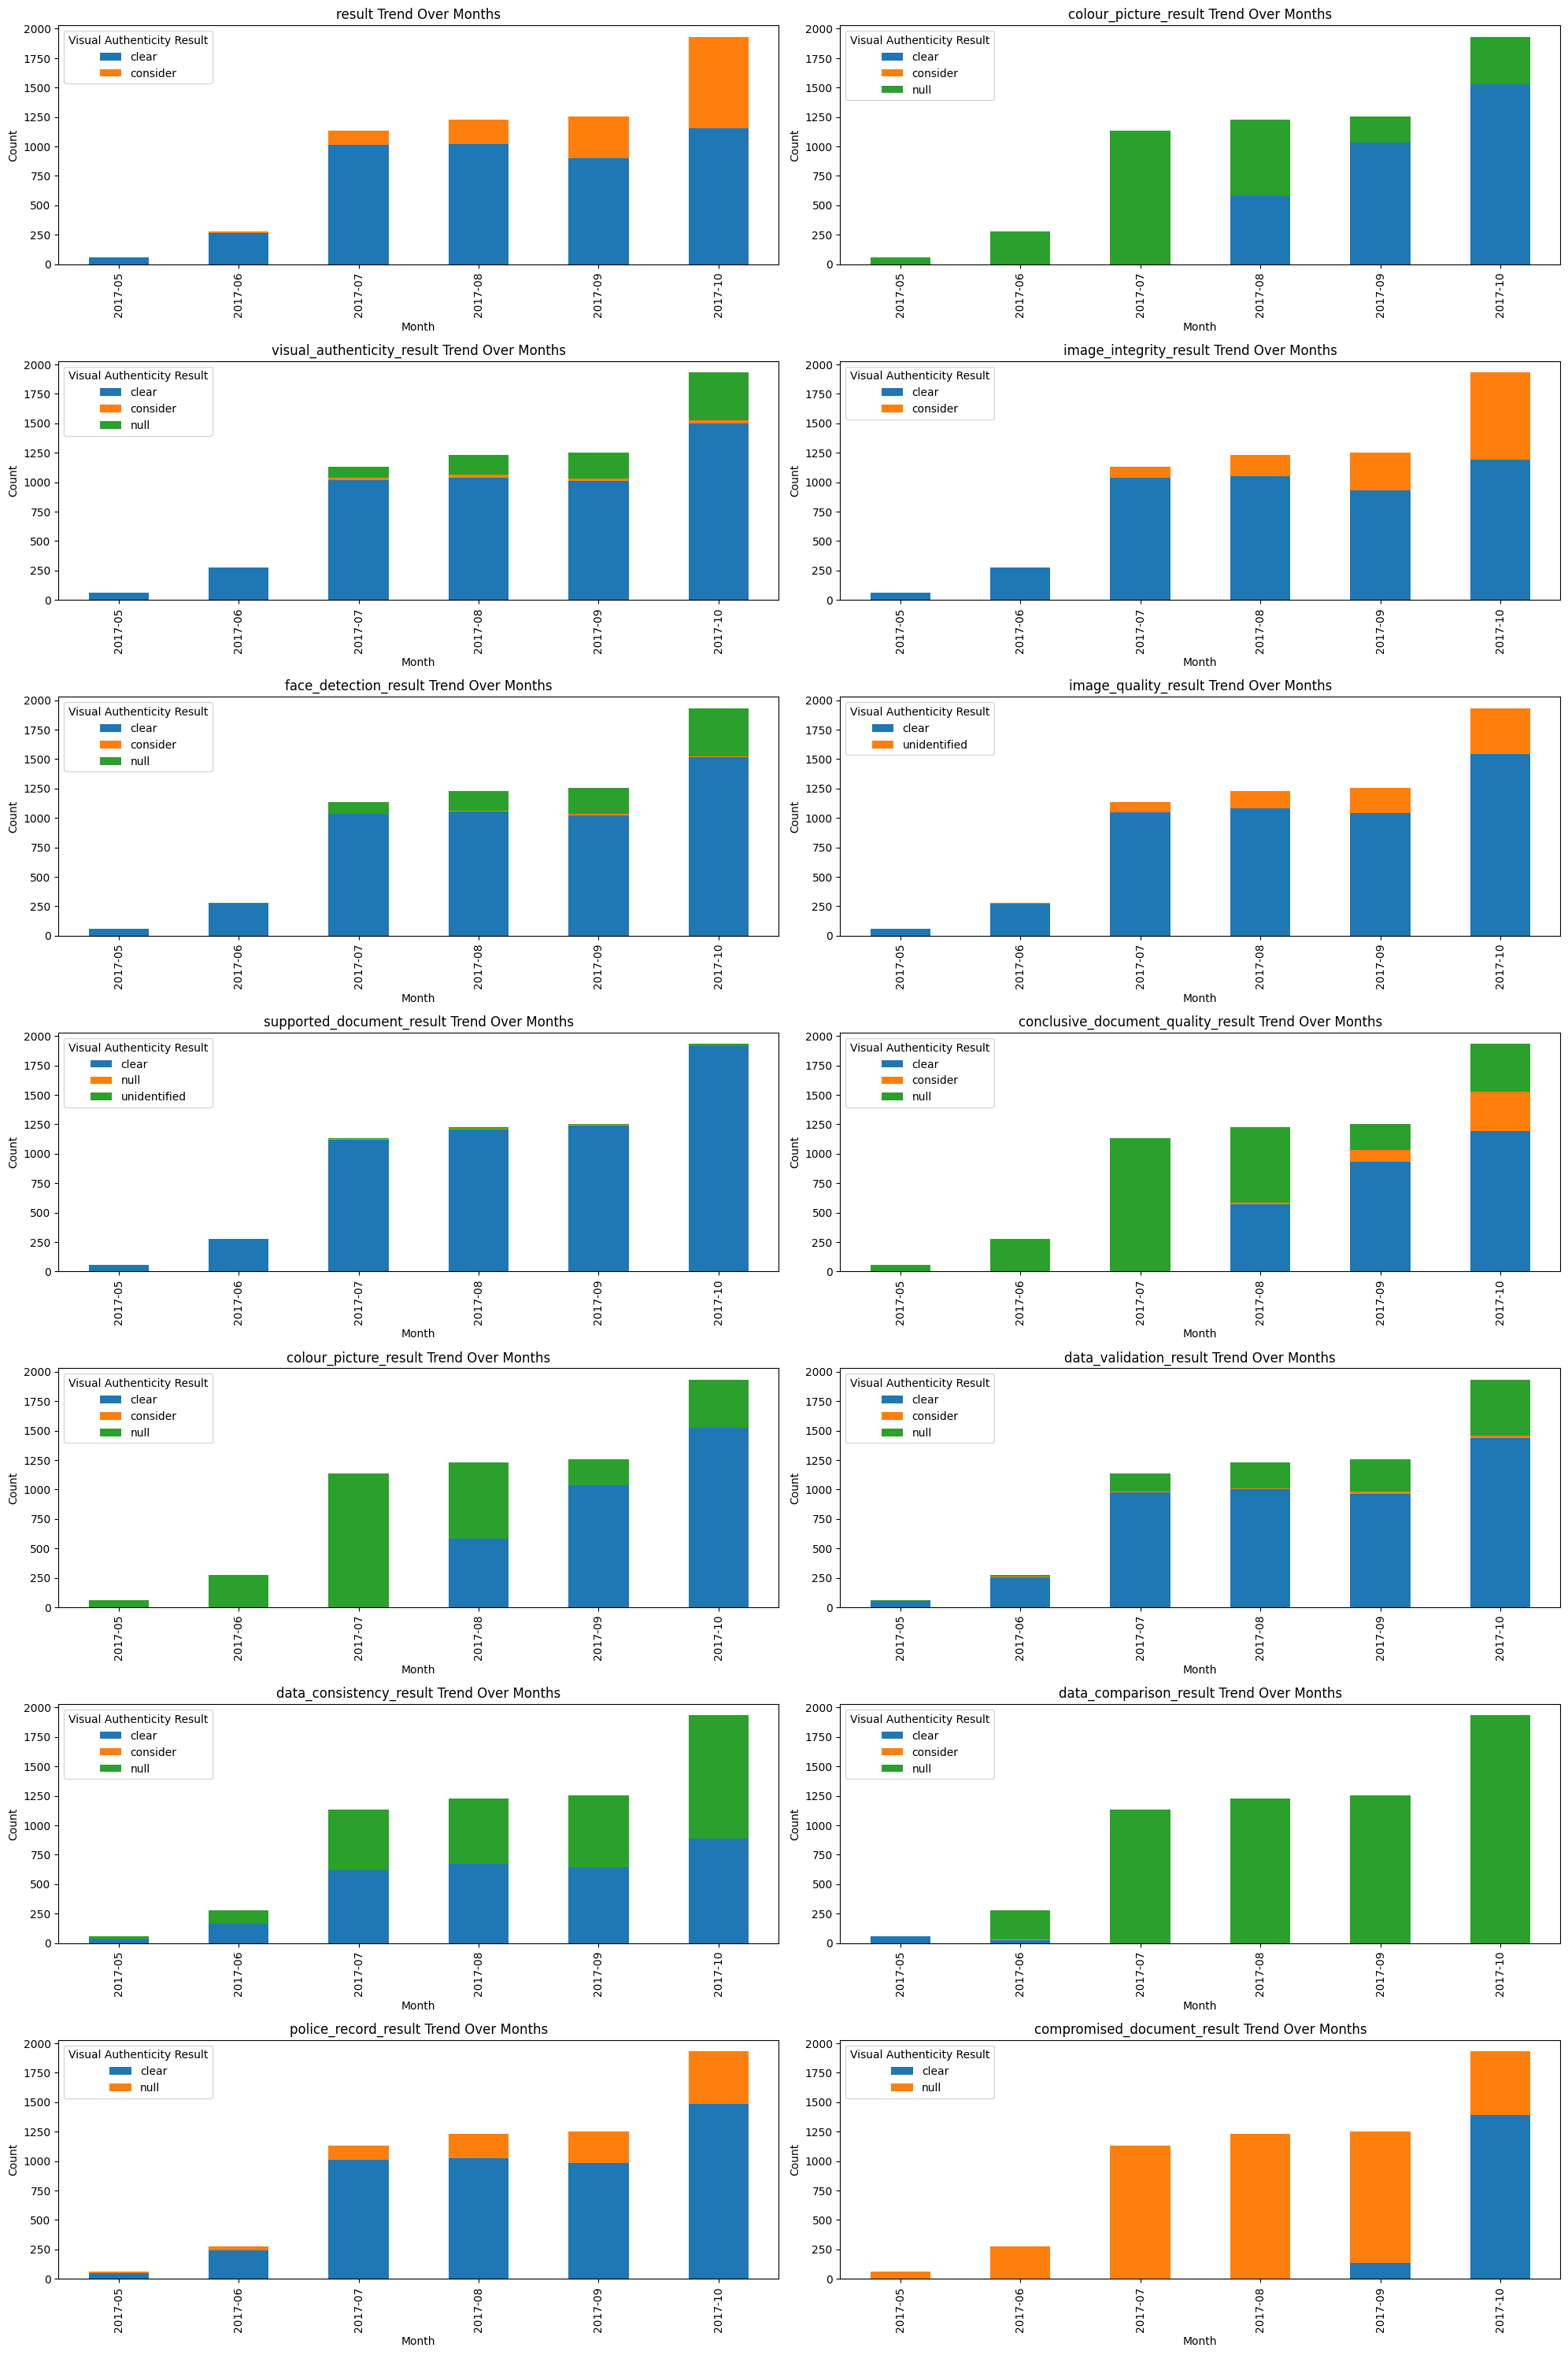

In [10]:
def plotting(result_counts, value, ax):
    result_counts.plot(kind='bar', stacked=True, figsize=(20, 30), ax=ax)

    # Add labels and title
    ax.set_title(value + ' Trend Over Months')
    ax.set_xlabel('Month')
    ax.set_ylabel('Count')
    ax.legend(title='Visual Authenticity Result')

# List of attribute to create plots
attr = ['result', 'colour_picture_result', 'visual_authenticity_result', 'image_integrity_result', 'face_detection_result', 'image_quality_result', 'supported_document_result', 'conclusive_document_quality_result', 'colour_picture_result',
 'data_validation_result',
 'data_consistency_result',
 'data_comparison_result',
 'police_record_result',
 'compromised_document_result' ]

# Set the number of columns for subplots
num_cols = 2
num_rows = -(-len(attr) // num_cols)  

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axs array in case there is only one row
axs = axs.flatten()

# Loop through attributes and create subplots
for i, value in enumerate(attr):
    divide = ['created_at', value]
    divided_doc = document_filtered[divide]
    result_counts = groupping(divided_doc, value)

    plotting(result_counts, value, axs[i])


plt.tight_layout(pad=1.0)
plt.show()


#### Explain visualization
<strong>Why</strong>
- From the visualization above, we can see the trend how each attribute changes over time, which one has signigicant changes that might affect the final result
- After remove the inrellevant attribute, we can move on further with the rest

<strong>Understand the attributes</strong>
- colour_picture_result: This could be the result for colored photo, which means they take in and analyze the colored photos 
- visual_authenticity_result: Elements such as watermark are authentic. 
- image_integrity_result: Checking for any sign of tempering with the image 
- face_detection_result: Ensure the document contain the valid image. 
- image_quality_result: Overall quality of the image 
- supported_document_result: Any supported document provided along 
- conclusive_document_quality_result: Focus more on the quality of the entire document
- data_validation_result: Check validity of data occur 
- data_consistency_result: Consistency of data across the entire document
- data_comparison_result: Compare with external databasese
- police_record_result: Check if the data is in police record
- compromised_document_result: Check if the document has been compormsed

<strong>What can we keep</strong> <br>
From the visualization, it is evident that some attributes, namely 'color_picture_result,' 'image_integrity_result,' and 'compromised_document_result,' exhibit significant changes that warrant further examination. However, the attribute 'compromised_document_result' has changed positively, with more documents now marked as clear. Therefore, my assumption is that the system, when using colored images, detects more image integrity issues, leading to a reduction in the number of rejected documents.

#### Analyze the realtion between 'result' and 'image_integrity_result' 

- We will use chi-square technique to identify the relation between this attribute and the final result

In [11]:
contingency_table = pd.crosstab(document_filtered['result'], document_filtered['image_integrity_result'])

print(contingency_table)

# Perform the chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)

print()
print(f"Chi-square: {chi2}")
print(f"P-value: {p}")


image_integrity_result  clear  consider
result                                 
clear                    4406         0
consider                  137      1337

Chi-square: 5167.487097916589
P-value: 0.0



#### Conclusion 1
Based on the chi-square test results, there is a statistically significant association between the 'result' and 'image_integrity_result' attributes.

The contingency table reveals a substantial discrepancy in the distribution of categories:
- In the 'clear' result category, the majority of documents (4406) are associated with 'clear' image integrity, and there are no instances of 'consider' image integrity.
- In the 'consider' result category, 137 documents have 'clear' image integrity, while 1337 documents have 'consider' image integrity.

The high chi-square statistic of 5167.49 indicates a significant difference in the observed and expected frequencies, supporting the notion that the two attributes are not independent. The p-value of 0.0 further corroborates this, suggesting that the association is unlikely to be due to chance.

Therefore, it appears that the 'image_integrity_result' attribute is related to the overall 'result' attribute. Specifically, the absence of 'clear' image integrity seems to be associated with a 'consider' result, while 'clear' image integrity is predominant in the 'clear' result category.

#### Analyze attribute properties 

- Since attribute is in different format so it is better to do separate pre-processing as below: 

In [12]:
document_filtered['properties'].unique()

array(["{'gender': 'Female', 'document_type': 'driving_licence', 'date_of_expiry': '2024-03-03', 'issuing_country': 'GBR'}",
       "{'nationality': 'DEU', 'document_type': 'national_identity_card', 'date_of_expiry': '2020-11-19', 'issuing_country': 'DEU'}",
       "{'gender': 'Female', 'nationality': 'FRA', 'document_type': 'passport', 'date_of_expiry': '2024-01-22', 'issuing_country': 'FRA'}",
       ...,
       "{'gender': 'Male', 'issuing_date': '2012-08-31', 'document_type': 'driving_licence', 'date_of_expiry': '2021-09-17', 'issuing_country': 'GBR'}",
       "{'gender': 'Female', 'issuing_date': '2015-04-17', 'document_type': 'driving_licence', 'date_of_expiry': '2025-04-16', 'issuing_country': 'GBR'}",
       "{'issuing_date': '2002-09-18', 'document_type': 'driving_licence', 'issuing_country': 'POL'}"],
      dtype=object)

- We can summarize this to null and available (with properties) to see if missing the properties will affect the approval rate

In [13]:
document_filtered['properties'] = document_filtered['properties'].apply(lambda x: 'null' if not x or x == '{}' else 'available')

In [14]:
attr_for_properties = ['created_at', 'properties']
df_for_properties = document_filtered[attr_for_properties]

In [15]:
result = df_for_properties.groupby([df_for_properties['created_at'].dt.to_period("M"), 'properties']).size().unstack(fill_value=0)
result.columns = ['Null', 'Available']

print(result)


            Null  Available
created_at                 
2017-05       58          0
2017-06      275          1
2017-07     1037         96
2017-08     1063        165
2017-09     1033        220
2017-10     1525        407


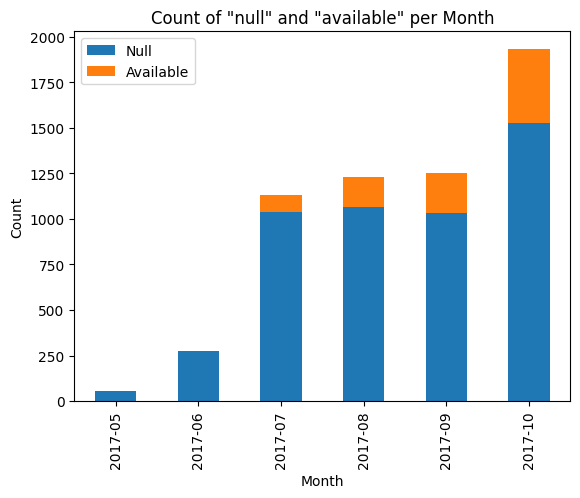

In [16]:
result.plot(kind='bar', stacked=True)
plt.title('Count of "null" and "available" per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()


#### Chi-square analysis for attribute properties

In [17]:
contingency_table = pd.crosstab(document_filtered['result'], document_filtered['properties'])

print(contingency_table)

# Perform the chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)

print()
print(f"Chi-square: {chi2}")
print(f"P-value: {p}")

properties  available  null
result                     
clear            4406     0
consider          585   889

Chi-square: 3125.9809713860427
P-value: 0.0


### Conclusion 2
Based on the results of the chi-square test, there is a statistically significant association between the 'result' and the 'properties' attributes.

The contingency table illustrates a notable disparity in the distribution of categories:
- In the 'clear' result category, all 4406 documents have the 'properties' marked as available, with no instances of null properties.
- In the 'consider' result category, 585 documents have available properties, while 889 documents have null properties.

The high chi-square statistic of 3125.98 indicates a substantial difference in the observed and expected frequencies, suggesting a significant association between the two attributes. The p-value of 0.0 reinforces this, indicating that the observed association is highly unlikely to occur by chance.

In conclusion, the 'properties' attribute appears to be closely related to the overall 'result' attribute. Specifically, the presence of available properties seems to be associated with a 'clear' result, while null properties are more prevalent in the 'consider' result category.

## Facial_report_sample File
Things we will do to the document file 
- Keep only relevant attributes 
- This is a time series problem -> ensure the date time format, sort the data according to the time 
- Generate visualization to understand how each attribute change over time 
- Select the attribute with noticable changes that might affect the final result 
- Confirm the assumption about that attribute using chi-square techniche: finding the relevance of categorical data 

#### Convert 'created_at' to the right format
- Currently, the date time is object so it will not be sorted correctly. We will convert that to date-time format

In [18]:
# Currently, the date time is object so it will not be sorted correctly. We will convert that to date-time format

facial_df['created_at'] = pd.to_datetime(document_df['created_at'], format='%d/%m/%Y %H:%M')
facial_df['created_at'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 5880 entries, 0 to 5879
Series name: created_at
Non-Null Count  Dtype         
--------------  -----         
5880 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 46.1 KB


#### Remove irrelevant attributes 
- To do this, we will create a subset of the initial dataframe, with only the important attributes

In [19]:
facial_importantArr = [
    'result', 
    'face_comparison_result',
    'created_at', 'facial_image_integrity_result',
    'visual_authenticity_result',
    'properties'
]

# Drop the inrellevant attributes 
facial_filtered = facial_df[facial_importantArr]
facial_filtered = facial_filtered.sort_values(by='created_at').reset_index(drop=True)

#### Check the unique values in all attributes 
- By doing this, we can ensure that the visualization are reasonable, without missing out any values 

In [20]:
# Check the unique values in all attributes 
# This step helps understanding what are in each attributes, then we can create suitable visualization

for attribute in facial_importantArr:
    unique_values = facial_filtered[attribute].unique()
    # print(f"Unique values for {attribute}:\n{unique_values}\n")


#### Creating visualization for all attribute over time
- In this case, I will use stacked bar chart, which can show the total, as well as the proportion of each value 
- Create the stacked bar chart for all related attributes 
- The pipeline to transform data, we can reuse the pipeline created above

C:\Users\vuanh\AppData\Local\Temp\ipykernel_15228\3791455114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  divided_doc[value] = divided_doc[value].fillna('null')
C:\Users\vuanh\AppData\Local\Temp\ipykernel_15228\3791455114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  divided_doc[value] = divided_doc[value].fillna('null')
C:\Users\vuanh\AppData\Local\Temp\ipykernel_15228\3791455114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

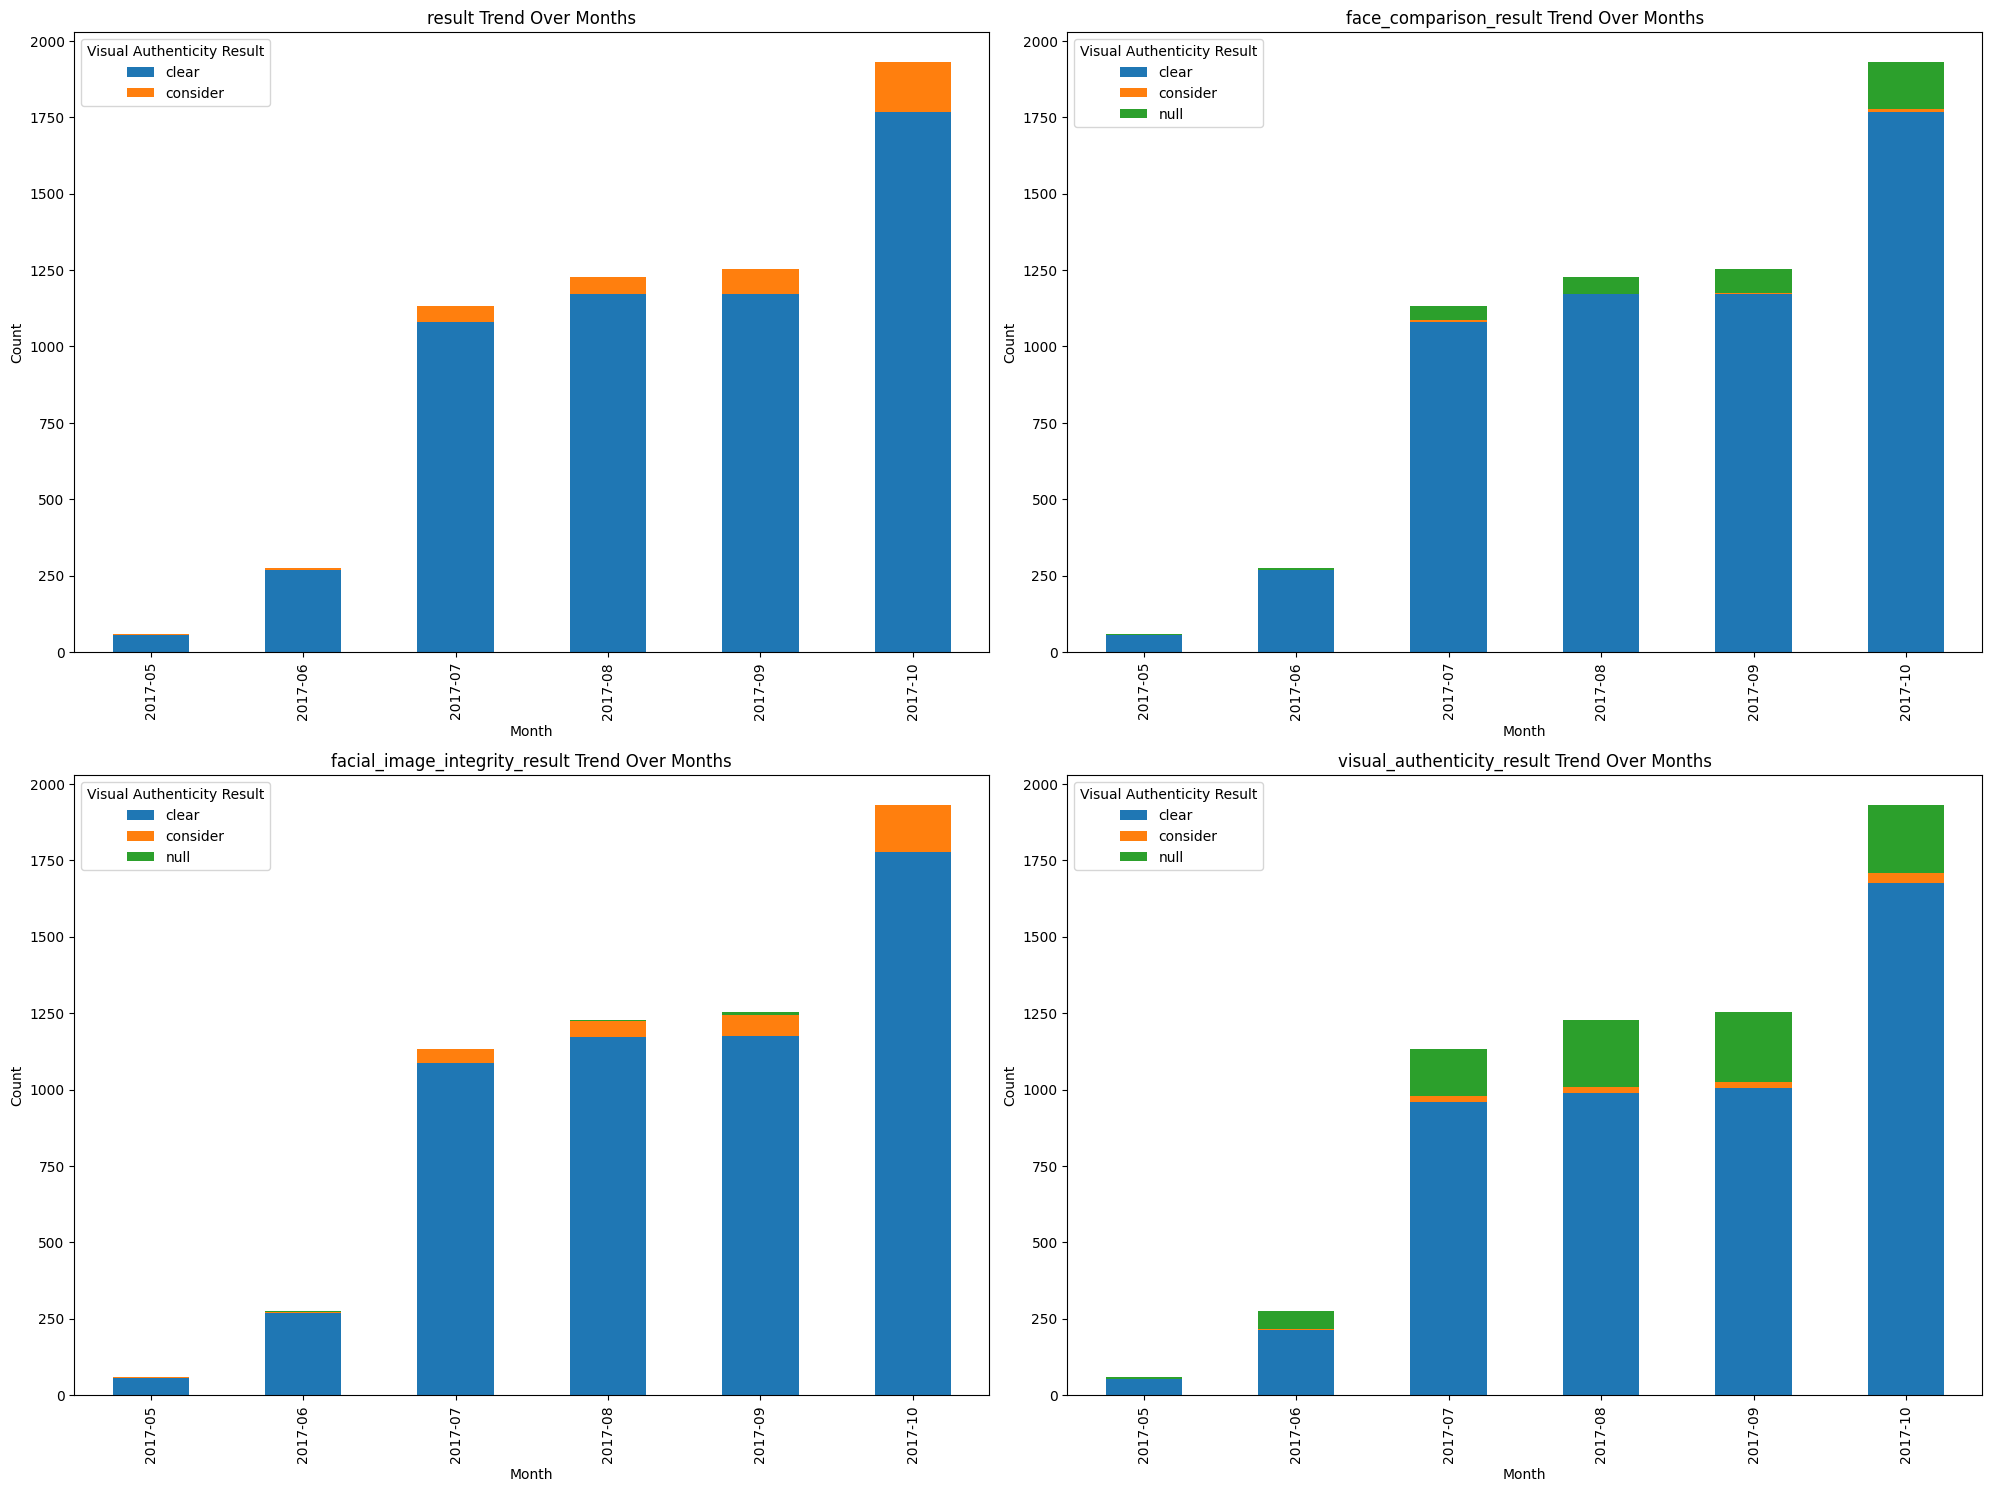

In [21]:
def plotting(result_counts, value, ax):
    result_counts.plot(kind='bar', stacked=True, figsize=(20, 15), ax=ax)

    # Add labels and title
    ax.set_title(value + ' Trend Over Months')
    ax.set_xlabel('Month')
    ax.set_ylabel('Count')
    ax.legend(title='Visual Authenticity Result')

# List of attribute to create plots
attr = ['result', 
    'face_comparison_result', 'facial_image_integrity_result', 'visual_authenticity_result' ]

# Set the number of columns for subplots
num_cols = 2
num_rows = -(-len(attr) // num_cols)  

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axs array in case there is only one row
axs = axs.flatten()

# Loop through attributes and create subplots
for i, value in enumerate(attr):
    divide = ['created_at', value]
    divided_doc = facial_filtered[divide]
    result_counts = groupping(divided_doc, value)

    plotting(result_counts, value, axs[i])


plt.tight_layout(pad=1.0)
plt.show()


#### Explain visulization 

- From these visualizations, we can see that the trend remains the same; the proportions of 'null,' 'consider,' and 'clear' do not change significantly. Hence, the problem might not be originating from any of these attributes.

#### Analyze properties attribute
- Because the attribute's format is different from the rest of the file, I will process and analyze it separately for a clearer explanation.

In [22]:
facial_filtered['properties'].unique()
#facial_filtered['properties'].info()

array(['{}', "{'score': 0.63}", "{'score': 0.73}", "{'score': 0.69}",
       "{'score': 0.71}", "{'score': 0.52}", "{'score': 0.65}",
       "{'score': 0.7}", "{'score': 0.56}", "{'score': 0.67}",
       "{'score': 0.66}", "{'score': 0.78}", "{'score': 0.62}",
       "{'score': 0.55}", "{'score': 0.85}", "{'score': 0.72}",
       "{'score': 0.16}", "{'score': 0.76}", "{'score': 0.74}",
       "{'score': 0.87}", "{'score': 0.58}", "{'score': 0.64}",
       "{'score': 0.57}", "{'score': 0.75}", "{'score': 0.82}",
       "{'score': 0.29}", "{'score': 0.68}", "{'score': 0.51}",
       "{'score': 0.77}", "{'score': 0.81}", "{'score': 0.6}",
       "{'score': 0.61}", "{'score': 0.59}", "{'score': 0.42}",
       "{'score': 0.2}", "{'score': 0.5}", "{'score': 0.46}",
       "{'score': 0.53}", "{'score': 0.05}", "{'score': 0.8}",
       "{'score': 0.54}"], dtype=object)

#### First method 
- Keep as categorical values 
- See if the 'properties' attribute contain or not contain information will affect anything

In [23]:
# Change to available or null. Available if contains score, and null if it is empty 

facial_filtered['properties'] = facial_filtered['properties'].apply(lambda x: 'null' if not x or x == '{}' else 'available')

In [24]:
attr_for_properties = ['created_at', 'properties']
df2_for_properties = facial_filtered[attr_for_properties]

In [25]:
result2 = df2_for_properties.groupby([df2_for_properties['created_at'].dt.to_period("M"), 'properties']).size().unstack(fill_value=0)
result2.columns = ['Null', 'Available']

print(result2)


            Null  Available
created_at                 
2017-05        2         56
2017-06        0        276
2017-07      101       1032
2017-08       11       1217
2017-09        0       1253
2017-10        0       1932


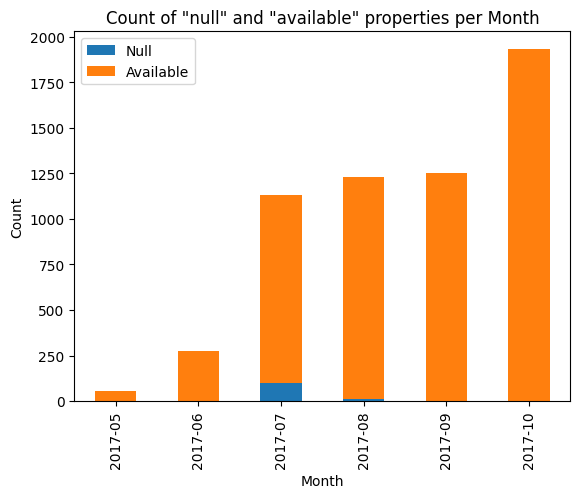

In [26]:
result2.plot(kind='bar', stacked=True)
plt.title('Count of "null" and "available" properties per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()


From the graph above, we can see that recently, there are more score available for data entries <br>
This could be the reason that lead to the decrease of approve KYC <br>
<br>
<strong>For more detailed information, we will analyze the score as numerical data</strong>

#### Second method 

- Convert the score to numerical values 
- Observe if higher or lower score will affect the resutl


- Based on the unique values, the 'properties' attribute will contain the score 
- We can transform this attribute to numerical values to see the correlation 
- For values with no score, we will keep as -1

In [27]:
# Sample data
data = facial_filtered['properties']

# Extract numeric values using regular expressions
facial_filtered['numeric_score'] = facial_filtered['properties'].apply(lambda x: float(re.search(r"\d+\.\d+", x).group()) if re.search(r"\d+\.\d+", x) else -1)

# Display the result
print(facial_filtered[['properties', 'numeric_score']])


     properties  numeric_score
0          null             -1
1          null             -1
2          null             -1
3          null             -1
4     available             -1
...         ...            ...
5875       null             -1
5876       null             -1
5877       null             -1
5878       null             -1
5879       null             -1

[5880 rows x 2 columns]


<strong>Calculate correlation</strong>

Correlation: Correlation is a statistical measure that quantifies the degree of association or relationship between two variables. <br>
What is a good correlation: The correlation coefficient is a numerical value that <strong>ranges from -1 to 1, with -1 indicating a perfect negative correlation, 1 indicating a perfect positive correlation, and 0 indicating no linear correlation<strong>.

In [28]:
# Calculate the correlation 

from sklearn.preprocessing import LabelEncoder
from scipy.stats import pearsonr

# Currently our lable are categorical. Convert them to numerical 
label_encoder = LabelEncoder()
facial_filtered['result_encoded'] = label_encoder.fit_transform(facial_filtered['result'])

correlation, p_value = pearsonr(facial_filtered['result_encoded'], facial_filtered['numeric_score'])

print(f"Correlation: {correlation}")
print(f"P-value: {p_value}")


Correlation: nan
P-value: nan


C:\Users\vuanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


## Conclusion 
After analyzing the visualization, and using various techniques such as chi-square and correlation, it can be concluded that the decrease in pass rates is primarily attributed to the document_check_sample file. This is evident from the significant changes in trends observed in this file, unlike the consistent trends found in the facial_report_sample.
<br>
<br>
In the document_check_sample file, a potential factor identified earlier is the 'image_integrity_result.' One plausible assumption regarding the root cause is the use of colored photos, which may either make integrity issues easier to detect or lead to confusion resulting in incorrect marking as 'consider' by the system.
<br>
<br>
To validate this hypothesis, the chi-square technique was employed, revealing that in cases where the integrity of images is marked as 'consider,' none of them are marked as 'clear' in the results. The high chi-square statistic of 5167.49 indicates a significant difference in observed and expected frequencies, supporting the idea that these two attributes are not independent.
<br>
<br>
As a temporary solution to address this root cause, I suggest discontinuing the use of the 'color_picture_result' attribute. This would prevent the system from marking too many 'consider' results for KYC. For a more long-term approach, it is essential to conduct tests to determine whether colored images genuinely aid in detecting integrity issues or if the system is prone to incorrect markings. Subsequently, the appropriate solution can be implemented to rectify this issue.